In [3]:
# Google Colab 새 노트북에서 실행

# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. 파일 경로 확인
import os

# 업로드한 파일 확인
drive_path = '/content/drive/MyDrive'
files = os.listdir(drive_path)
print("드라이브 파일 목록:")
for file in files:
    if '.zip' in file or 'archive' in file:
        print(f"  - {file}")

# 3. 압축 파일 경로 설정
zip_path = '/content/drive/MyDrive/archive.zip'
if not os.path.exists(zip_path):
    # 다른 이름으로 있을 수 있음
    zip_files = [f for f in files if f.endswith('.zip')]
    if zip_files:
        zip_path = f'/content/drive/MyDrive/{zip_files[0]}'
        print(f"대체 파일 사용: {zip_path}")
    else:
        print("zip 파일을 찾을 수 없습니다!")

Mounted at /content/drive
드라이브 파일 목록:
  - RaidaR.zip
  - test.zip
  - train_img.zip
  - archive.zip


In [4]:
# 압축 해제 없이 데이터셋 구조 확인
import zipfile

def explore_zip_structure(zip_path):
    """zip 파일 내부 구조 확인"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 모든 파일 목록
        all_files = zip_ref.namelist()
        print(f"총 파일 수: {len(all_files)}")

        # 디렉토리 구조 확인
        dirs = set()
        for file in all_files:
            dir_path = os.path.dirname(file)
            if dir_path:
                dirs.add(dir_path)

        print("\n주요 디렉토리:")
        for d in sorted(list(dirs))[:10]:  # 처음 10개만
            print(f"  - {d}/")

        # 이미지 파일 통계
        image_ext = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
        image_files = [f for f in all_files if f.lower().endswith(image_ext)]

        print(f"\n이미지 파일: {len(image_files)}개")

        # 처음 10개 파일 샘플
        print("\n파일 샘플:")
        for img in image_files[:10]:
            print(f"  - {img}")

        return all_files, image_files

# 실행
all_files, image_files = explore_zip_structure(zip_path)

총 파일 수: 10918

주요 디렉토리:
  - depth_rain/train/aachen/
  - depth_rain/train/bochum/
  - depth_rain/train/bremen/
  - depth_rain/train/cologne/
  - depth_rain/train/dusseldorf/
  - depth_rain/train/erfurt/
  - depth_rain/train/hanover/
  - depth_rain/train/jena/
  - depth_rain/train/weimar/
  - depth_rain/val/lindau/

이미지 파일: 10915개

파일 샘플:
  - depth_rain/train/aachen/aachen_000004_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000007_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000008_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000009_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000015_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000031_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000032_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000034_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000036_000019_depth_rain.png
  - depth_rain/train/aachen/aachen_000037_000019_depth_rain.png


In [5]:
# 데이터셋 더 자세히 분석
import zipfile
import pandas as pd
from collections import defaultdict

def analyze_dataset_structure(zip_path):
    """데이터셋 구조 심층 분석"""

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()

        # 통계 수집
        stats = defaultdict(int)
        city_stats = defaultdict(int)
        split_stats = defaultdict(int)
        type_stats = defaultdict(int)

        for file in all_files:
            # 경로 분석
            parts = file.split('/')

            if len(parts) >= 3:
                # depth_rain/train/aachen/...
                split_type = parts[1]  # train 또는 val
                city = parts[2]  # 도시명
                filename = parts[-1]

                split_stats[split_type] += 1
                city_stats[city] += 1

                # 파일 유형 분석
                if '_depth_rain.png' in filename:
                    type_stats['depth_rain'] += 1
                elif '_depth.png' in filename:
                    type_stats['depth'] += 1
                elif '_rain.png' in filename:
                    type_stats['rain'] += 1
                elif '.png' in filename:
                    type_stats['other_png'] += 1
                else:
                    type_stats['other'] += 1

        print("📊 데이터셋 상세 분석")
        print("=" * 50)

        print("\n📁 Split별 분포:")
        for split, count in split_stats.items():
            print(f"  {split}: {count}개")

        print("\n🏙️ 도시별 분포:")
        for city, count in sorted(city_stats.items(), key=lambda x: x[1], reverse=True)[:15]:
            print(f"  {city}: {count}개")

        print("\n📄 파일 유형별 분포:")
        for file_type, count in type_stats.items():
            print(f"  {file_type}: {count}개")

        return split_stats, city_stats, type_stats

# 분석 실행
split_stats, city_stats, type_stats = analyze_dataset_structure(zip_path)

📊 데이터셋 상세 분석

📁 Split별 분포:
  train: 9694개
  val: 1221개

🏙️ 도시별 분포:
  dusseldorf: 2516개
  aachen: 2405개
  erfurt: 2183개
  bremen: 1961개
  munster: 1110개
  bochum: 222개
  cologne: 185개
  hanover: 111개
  lindau: 111개
  jena: 74개
  weimar: 37개

📄 파일 유형별 분포:
  depth_rain: 295개
  other_png: 10620개


In [6]:
# 먼저 필요한 변수 설정
import os

# Google Drive에서 zip 파일 경로 설정
zip_path = '/content/drive/MyDrive/archive.zip'

# 파일 존재 확인
if os.path.exists(zip_path):
    print(f"✅ 파일 발견: {zip_path}")
    print(f"파일 크기: {os.path.getsize(zip_path)/1024**3:.1f} GB")
else:
    # 다른 가능한 경로 확인
    drive_path = '/content/drive/MyDrive'
    files = os.listdir(drive_path)
    zip_files = [f for f in files if f.endswith('.zip')]

    if zip_files:
        zip_path = f'/content/drive/MyDrive/{zip_files[0]}'
        print(f"✅ 대체 파일 사용: {zip_path}")
    else:
        print("❌ zip 파일을 찾을 수 없습니다!")
        print(f"드라이브 파일 목록: {files}")

✅ 파일 발견: /content/drive/MyDrive/archive.zip
파일 크기: 20.5 GB


In [7]:
print("🔍 실제 처리할 이미지 파일 찾기...")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    all_files = zip_ref.namelist()

    # 1. 실제 도시 이미지 파일 찾기 (leftImg8bit)
    city_images = []
    depth_rain_images = []

    for file in all_files:
        if file.endswith('.png'):
            if 'leftImg8bit' in file:
                city_images.append(file)
            elif '_depth_rain' in file:
                depth_rain_images.append(file)

    print(f"📊 실제 이미지 파일:")
    print(f"  - 도시 이미지 (leftImg8bit): {len(city_images)}개")
    print(f"  - 비 효과 이미지 (depth_rain): {len(depth_rain_images)}개")

    # 2. 처리할 대상 선택 (도시 이미지를 우선)
    # 10,000개로 제한하되, depth_rain 이미지도 포함
    target_images = []

    # 먼저 depth_rain 이미지 추가
    if depth_rain_images:
        target_images.extend(depth_rain_images)
        print(f"  - depth_rain 추가: {len(depth_rain_images)}개")

    # 나머지를 city_images로 채우기
    remaining = 10000 - len(target_images)
    if remaining > 0:
        target_images.extend(city_images[:remaining])
        print(f"  - 도시 이미지 추가: {min(remaining, len(city_images))}개")

    print(f"\n🎯 총 처리 대상: {len(target_images)}개 이미지")

    # 3. 샘플 확인
    print("\n📋 샘플 파일명:")
    for img in target_images[:5]:
        print(f"  - {os.path.basename(img)}")

🔍 실제 처리할 이미지 파일 찾기...
📊 실제 이미지 파일:
  - 도시 이미지 (leftImg8bit): 10620개
  - 비 효과 이미지 (depth_rain): 295개
  - depth_rain 추가: 295개
  - 도시 이미지 추가: 9705개

🎯 총 처리 대상: 10000개 이미지

📋 샘플 파일명:
  - aachen_000004_000019_depth_rain.png
  - aachen_000007_000019_depth_rain.png
  - aachen_000008_000019_depth_rain.png
  - aachen_000009_000019_depth_rain.png
  - aachen_000015_000019_depth_rain.png


In [15]:
import os
import zipfile
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from tqdm import tqdm

def clean_dataset(zip_path):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"zip 파일 없음: {zip_path}")

    valid_images = []
    removed = 0

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()

        # 이미지 파일만 선택
        candidates = [
            f for f in all_files
            if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.endswith('/')
        ]

        print(f"검사 대상 이미지 수: {len(candidates)}")

        for f in tqdm(candidates):
            try:
                with zip_ref.open(f) as fp:
                    img = Image.open(fp)
                    img.load()     # 실제 픽셀 로딩 → 무결성 검사
                valid_images.append(f)

            except Exception:
                removed += 1

    print("\n🧹 정제 완료")
    print(f"  - 유효한 이미지: {len(valid_images)}개")
    print(f"  - 손상된 이미지: {removed}개")

    return valid_images

# 실행
cleaned_files = clean_dataset(zip_path)


검사 대상 이미지 수: 10915


100%|██████████| 10915/10915 [21:39<00:00,  8.40it/s]


🧹 정제 완료
  - 유효한 이미지: 10915개
  - 손상된 이미지: 0개


In [16]:
# 낮 / 밤 / 비 이미지 분류
day_images = [f for f in cleaned_files if "night" not in f.lower()]
night_images = [f for f in cleaned_files if "night" in f.lower()]
rain_images = [f for f in cleaned_files if "_rain" in f.lower()]
depth_rain_images = [f for f in cleaned_files if "_depth_rain" in f.lower()]

print("📊 이미지 개수 분석 결과")
print(f"  - 낮(day): {len(day_images)}개")
print(f"  - 밤(night): {len(night_images)}개")
print(f"  - 비(rain): {len(rain_images)}개")
print(f"  - depth_rain: {len(depth_rain_images)}개")


📊 이미지 개수 분석 결과
  - 낮(day): 10915개
  - 밤(night): 0개
  - 비(rain): 10915개
  - depth_rain: 295개


Step 1: Collecting brightness data from ALL images...
Classifying all images as day/night based on brightness...


Analyzing brightness: 100%|██████████| 10915/10915 [23:47<00:00,  7.65it/s]



📊 Brightness Analysis Results (All 10915 images):
  Mean brightness: 105.3
  Std deviation: 23.5
  Min brightness: 63.3
  Max brightness: 232.9


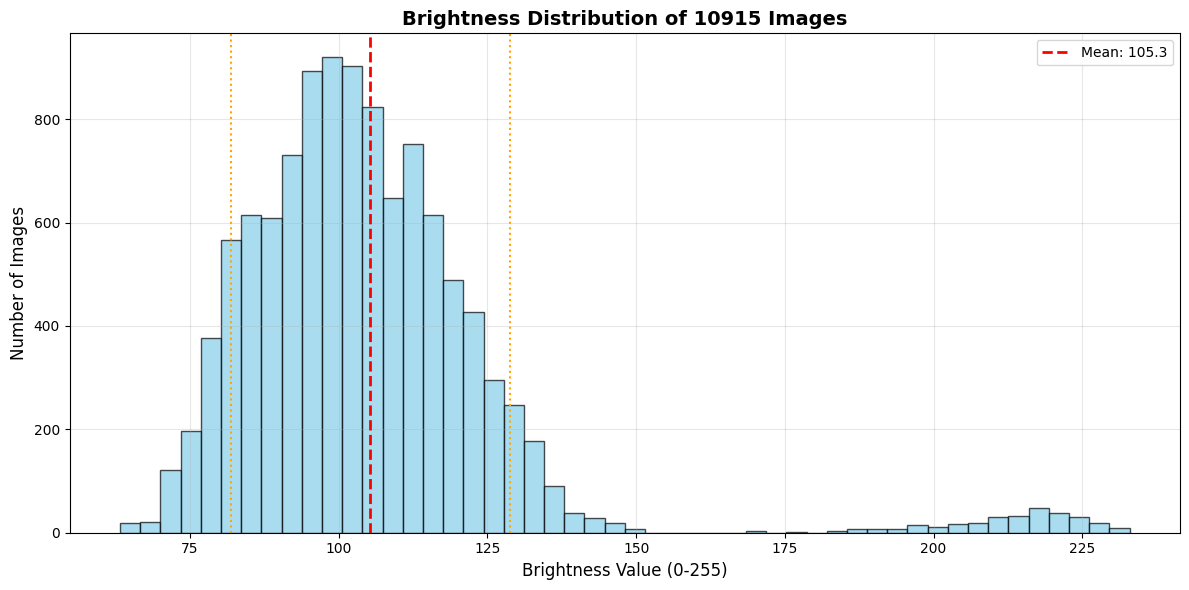


🎯 Optimal threshold for 50.0% night images: 102.1

Step 4: Classifying ALL images...
Classifying all images as day/night based on brightness...


Analyzing brightness: 100%|██████████| 10915/10915 [22:15<00:00,  8.17it/s]


✅ FINAL CLASSIFICATION RESULTS:
  Total images: 10915
  Day images: 5458 (50.0%)
  Night images: 5457 (50.0%)


In [22]:
  import numpy as np
  from PIL import Image
  import zipfile
  from tqdm import tqdm
  import matplotlib.pyplot as plt
  import os

  def classify_day_night_all_images(zip_path, image_list, brightness_threshold=None):
      """
      모든 이미지를 밝기 기준으로 낮/밤으로 분류
      """
      print("Classifying all images as day/night based on brightness...")

      day_images = []
      night_images = []
      brightness_values = []

      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          for f in tqdm(image_list, desc="Analyzing brightness"):
              try:
                  with zip_ref.open(f) as fp:
                      img = Image.open(fp)
                      img_gray = img.convert('L')  # Convert to grayscale

                      # Calculate average brightness
                      brightness = np.mean(np.array(img_gray))
                      brightness_values.append(brightness)

                      # Store image path with its brightness
                      if brightness_threshold is None:
                          # Just collect data, don't classify yet
                          continue
                      elif brightness >= brightness_threshold:
                          day_images.append((f, brightness))
                      else:
                          night_images.append((f, brightness))
              except Exception as e:
                  # In case of error, skip or classify as day
                  print(f"Error processing {f}: {e}")
                  continue

      # If threshold is not provided, return brightness values for analysis
      if brightness_threshold is None:
          return brightness_values

      return day_images, night_images, brightness_values

  def analyze_brightness_distribution(brightness_values):
      """Analyze brightness distribution of all images"""
      if not brightness_values:
          print("No brightness data available")
          return None, None

      # Calculate statistics
      mean_brightness = np.mean(brightness_values)
      std_brightness = np.std(brightness_values)
      min_brightness = np.min(brightness_values)
      max_brightness = np.max(brightness_values)

      print(f"\n📊 Brightness Analysis Results (All {len(brightness_values)} images):")
      print(f"  Mean brightness: {mean_brightness:.1f}")
      print(f"  Std deviation: {std_brightness:.1f}")
      print(f"  Min brightness: {min_brightness:.1f}")
      print(f"  Max brightness: {max_brightness:.1f}")

      # Create histogram
      plt.figure(figsize=(12, 6))

      # Histogram
      plt.hist(brightness_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

      # Add vertical lines for statistics
      plt.axvline(mean_brightness, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_brightness:.1f}')
      plt.axvline(mean_brightness - std_brightness, color='orange', linestyle=':', linewidth=1.5)
      plt.axvline(mean_brightness + std_brightness, color='orange', linestyle=':', linewidth=1.5)

      plt.xlabel('Brightness Value (0-255)', fontsize=12)
      plt.ylabel('Number of Images', fontsize=12)
      plt.title(f'Brightness Distribution of {len(brightness_values)} Images', fontsize=14, fontweight='bold')
      plt.grid(True, alpha=0.3)
      plt.legend()
      plt.tight_layout()
      plt.show()

      return mean_brightness, std_brightness

  def determine_optimal_threshold(brightness_values, target_night_ratio=0.5):
      """
      Determine optimal brightness threshold for desired night ratio
      target_night_ratio: desired proportion of night images (0.0 to 1.0)
      """
      if not brightness_values:
          return 128

      # Sort brightness values
      sorted_brightness = sorted(brightness_values)

      # Find threshold for desired night ratio
      # Night images are darker (lower brightness)
      target_index = int(len(sorted_brightness) * target_night_ratio)

      if target_index >= len(sorted_brightness):
          optimal_threshold = sorted_brightness[-1]
      else:
          optimal_threshold = sorted_brightness[target_index]

      print(f"\n🎯 Optimal threshold for {target_night_ratio*100:.1f}% night images: {optimal_threshold:.1f}")

      return optimal_threshold

  # Step 1: Analyze brightness of ALL images
  print("Step 1: Collecting brightness data from ALL images...")
  all_brightness = classify_day_night_all_images(zip_path, cleaned_files, brightness_threshold=None)

  # Step 2: Analyze distribution
  mean_brightness, std_brightness = analyze_brightness_distribution(all_brightness)

  # Step 3: Determine optimal threshold (e.g., for 50% day, 50% night)
  optimal_threshold = determine_optimal_threshold(all_brightness, target_night_ratio=0.5)

  # Step 4: Classify ALL images with optimal threshold
  print("\nStep 4: Classifying ALL images...")
  day_images, night_images, _ = classify_day_night_all_images(zip_path, cleaned_files, brightness_threshold=optimal_threshold)

  print(f"\n✅ FINAL CLASSIFICATION RESULTS:")
  print(f"  Total images: {len(cleaned_files)}")
  print(f"  Day images: {len(day_images)} ({len(day_images)/len(cleaned_files)*100:.1f}%)")
  print(f"  Night images: {len(night_images)} ({len(night_images)/len(cleaned_files)*100:.1f}%)")

In [23]:
# 분류된 경로만 추출 (간단하게)
day_paths = [path for path, _ in day_images]
night_paths = [path for path, _ in night_images]

print("💾 분류 결과 저장 중...")

# JSON 파일로 저장
import json
classification_result = {
    'day_images': day_paths,
    'night_images': night_paths,
    'total_images': len(cleaned_files),
    'threshold': 102.1
}

with open('day_night_classification.json', 'w') as f:
    json.dump(classification_result, f, indent=2)

print("✅ 분류 결과 저장 완료!")
print(f"📁 파일명: day_night_classification.json")
print(f"📊 저장된 데이터:")
print(f"  - 낮 이미지: {len(day_paths)}개")
print(f"  - 밤 이미지: {len(night_paths)}개")
print(f"  - 총 이미지: {len(cleaned_files)}개")

💾 분류 결과 저장 중...
✅ 분류 결과 저장 완료!
📁 파일명: day_night_classification.json
📊 저장된 데이터:
  - 낮 이미지: 5458개
  - 밤 이미지: 5457개
  - 총 이미지: 10915개



👀 분류 결과 무작위 샘플 확인...


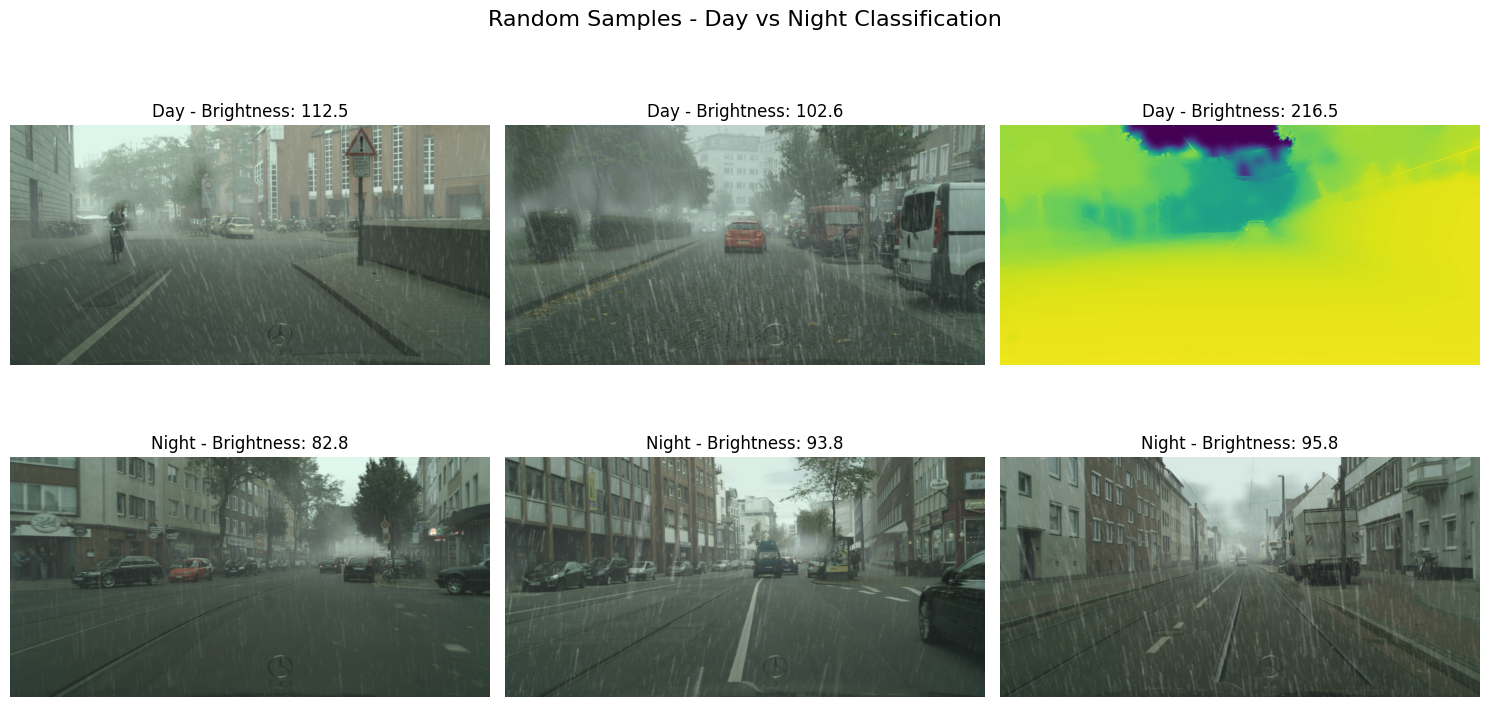

In [24]:
import matplotlib.pyplot as plt

def check_random_samples(zip_path, day_list, night_list, num_samples=3):
    """무작위 샘플로 분류 결과 확인"""

    import random
    random.seed(42)  # 재현성을 위해

    # 무작위 샘플 선택
    day_samples = random.sample(day_list, min(num_samples, len(day_list)))
    night_samples = random.sample(night_list, min(num_samples, len(night_list)))

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 낮 이미지 표시
        for i, (img_path, brightness) in enumerate(day_samples):
            with zip_ref.open(img_path) as fp:
                img = Image.open(fp)
                if num_samples == 1:
                    axes[0].imshow(img)
                    axes[0].set_title(f'Day - Brightness: {brightness:.1f}')
                    axes[0].axis('off')
                else:
                    axes[0, i].imshow(img)
                    axes[0, i].set_title(f'Day - Brightness: {brightness:.1f}')
                    axes[0, i].axis('off')

        # 밤 이미지 표시
        for i, (img_path, brightness) in enumerate(night_samples):
            with zip_ref.open(img_path) as fp:
                img = Image.open(fp)
                if num_samples == 1:
                    axes[1].imshow(img)
                    axes[1].set_title(f'Night - Brightness: {brightness:.1f}')
                    axes[1].axis('off')
                else:
                    axes[1, i].imshow(img)
                    axes[1, i].set_title(f'Night - Brightness: {brightness:.1f}')
                    axes[1, i].axis('off')

    plt.suptitle('Random Samples - Day vs Night Classification', fontsize=16)
    plt.tight_layout()
    plt.show()

# 샘플 확인 실행 (3개씩)
print("\n👀 분류 결과 무작위 샘플 확인...")
check_random_samples(zip_path, day_images, night_images, num_samples=3)

In [25]:
# 간단한 분석 리포트
print("\n📊 분류 결과 분석 리포트")
print("="*50)

# 밝기 통계 계산
day_brightness = [b for _, b in day_images]
night_brightness = [b for _, b in night_images]

print(f"📈 밝기 통계:")
print(f"  낮 이미지 평균 밝기: {sum(day_brightness)/len(day_brightness):.1f}")
print(f"  밤 이미지 평균 밝기: {sum(night_brightness)/len(night_brightness):.1f}")
print(f"  전체 평균 밝기: {(sum(day_brightness)+sum(night_brightness))/len(cleaned_files):.1f}")

# 파일명 패턴 확인
print(f"\n📁 파일명 패턴:")
print(f"  총 고유 경로: {len(set([os.path.dirname(p) for p, _ in day_images + night_images]))}개")


📊 분류 결과 분석 리포트
📈 밝기 통계:
  낮 이미지 평균 밝기: 120.4
  밤 이미지 평균 밝기: 90.2
  전체 평균 밝기: 105.3

📁 파일명 패턴:
  총 고유 경로: 22개


In [27]:
print("""
🎯 다음 단계 선택:

[1] 기본 분할: 간단히 train/val/test로 나누기
[2] 상세 정제: 이미지 크기 통일, 품질 검사 등
[3] 모델 학습 준비: PyTorch/TensorFlow 데이터로더 만들기
[4] 다른 분류 기준 시도: 밝기 외에 다른 특징으로 분류
[5] 현재 결과로 바로 모델 학습 시작

💡 추천: 샘플 이미지를 보고 분류가 괜찮다면 [1] 선택
""")

# 선택 입력 받기
choice = input("선택 (1-5): ")
print(f"\n✅ 선택하신 번호: {choice}")


🎯 다음 단계 선택:

[1] 기본 분할: 간단히 train/val/test로 나누기
[2] 상세 정제: 이미지 크기 통일, 품질 검사 등
[3] 모델 학습 준비: PyTorch/TensorFlow 데이터로더 만들기
[4] 다른 분류 기준 시도: 밝기 외에 다른 특징으로 분류
[5] 현재 결과로 바로 모델 학습 시작

💡 추천: 샘플 이미지를 보고 분류가 괜찮다면 [1] 선택

선택 (1-5): 1

✅ 선택하신 번호: 1


In [28]:
if choice == '1':
    print("\n✅ 기본 데이터 분할을 시작합니다...")

    # day_paths와 night_paths가 이미 정의되어 있다고 가정
    # 만약 안 되어 있다면 먼저 이 코드 실행:
    # day_paths = [path for path, _ in day_images]
    # night_paths = [path for path, _ in night_images]

    def split_dataset(day_paths, night_paths, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        """데이터를 train/val/test로 분할"""

        # 비율 검증
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.01, "비율 합이 1이어야 함"

        # 셔플을 위한 인덱스
        import random
        random.seed(42)  # 재현성을 위해

        # 낮 이미지 분할
        random.shuffle(day_paths)
        day_train_end = int(len(day_paths) * train_ratio)
        day_val_end = day_train_end + int(len(day_paths) * val_ratio)

        day_train = day_paths[:day_train_end]
        day_val = day_paths[day_train_end:day_val_end]
        day_test = day_paths[day_val_end:]

        # 밤 이미지 분할
        random.shuffle(night_paths)
        night_train_end = int(len(night_paths) * train_ratio)
        night_val_end = night_train_end + int(len(night_paths) * val_ratio)

        night_train = night_paths[:night_train_end]
        night_val = night_paths[night_train_end:night_val_end]
        night_test = night_paths[night_val_end:]

        # 통합
        train_set = day_train + night_train
        val_set = day_val + night_val
        test_set = day_test + night_test

        # 결과 출력
        print("\n📊 데이터 분할 완료!")
        print("="*50)
        print(f"총 이미지: {len(train_set) + len(val_set) + len(test_set)}")
        print(f"Train 세트: {len(train_set)}개 ({len(train_set)/len(day_paths+night_paths)*100:.1f}%)")
        print(f"  - 낮: {len(day_train)}, 밤: {len(night_train)}")
        print(f"Val 세트: {len(val_set)}개 ({len(val_set)/len(day_paths+night_paths)*100:.1f}%)")
        print(f"  - 낮: {len(day_val)}, 밤: {len(night_val)}")
        print(f"Test 세트: {len(test_set)}개 ({len(test_set)/len(day_paths+night_paths)*100:.1f}%)")
        print(f"  - 낮: {len(day_test)}, 밤: {len(night_test)}")

        # 분할 저장
        splits = {
            'train': train_set,
            'val': val_set,
            'test': test_set,
            'train_day': day_train,
            'train_night': night_train,
            'val_day': day_val,
            'val_night': night_val,
            'test_day': day_test,
            'test_night': night_test
        }

        import json
        with open('dataset_splits.json', 'w') as f:
            json.dump({
                'train': train_set,
                'val': val_set,
                'test': test_set,
                'train_size': len(train_set),
                'val_size': len(val_set),
                'test_size': len(test_set)
            }, f, indent=2)

        print(f"\n💾 분할 결과 저장됨: dataset_splits.json")

        return splits

    # 실행 (day_paths, night_paths가 있어야 함)
    if 'day_paths' in locals() and 'night_paths' in locals():
        dataset_splits = split_dataset(day_paths, night_paths)
    else:
        print("⚠️ 먼저 day_paths와 night_paths를 정의해주세요.")
        print("다음 코드를 먼저 실행하세요:")
        print("""
day_paths = [path for path, _ in day_images]
night_paths = [path for path, _ in night_images]
        """)


✅ 기본 데이터 분할을 시작합니다...

📊 데이터 분할 완료!
총 이미지: 10915
Train 세트: 7639개 (70.0%)
  - 낮: 3820, 밤: 3819
Val 세트: 1636개 (15.0%)
  - 낮: 818, 밤: 818
Test 세트: 1640개 (15.0%)
  - 낮: 820, 밤: 820

💾 분할 결과 저장됨: dataset_splits.json


In [29]:
import numpy as np
from PIL import Image, ImageFilter
import zipfile
from tqdm import tqdm
import hashlib

def complete_data_cleaning(zip_path, dataset_splits):
    """
    완전한 데이터 정제 파이프라인
    """
    print("="*60)
    print("🧹 COMPLETE DATA CLEANING PIPELINE")
    print("="*60)

    # 모든 이미지 경로 수집 (train + val + test)
    all_images = dataset_splits['train'] + dataset_splits['val'] + dataset_splits['test']

    print(f"🔍 정제할 총 이미지: {len(all_images)}개")

    # 정제 결과 저장용
    cleaning_report = {
        'total_processed': 0,
        'resized_images': 0,
        'quality_issues_found': 0,
        'duplicates_found': 0,
        'cleaned_images': []
    }

    # 1. 이미지 크기 분석
    print("\n1️⃣ STEP 1: 이미지 크기 분석 중...")
    sizes = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_path in tqdm(all_images[:100], desc="크기 샘플 분석"):  # 샘플 100개만
            try:
                with zip_ref.open(img_path) as fp:
                    img = Image.open(fp)
                    sizes.append(img.size)
            except:
                continue

    if sizes:
        avg_width = sum(s[0] for s in sizes) / len(sizes)
        avg_height = sum(s[1] for s in sizes) / len(sizes)
        print(f"   평균 크기: {avg_width:.0f}x{avg_height:.0f}")
        print(f"   최소 크기: {min(s[0] for s in sizes)}x{min(s[1] for s in sizes)}")
        print(f"   최대 크기: {max(s[0] for s in sizes)}x{max(s[1] for s in sizes)}")

    # 2. 품질 검사 (흐릿함, 대비, 밝기)
    print("\n2️⃣ STEP 2: 이미지 품질 검사 중...")

    def check_image_quality(img):
        """이미지 품질 검사"""
        issues = []

        # 그레이스케일로 변환
        img_gray = img.convert('L')
        img_array = np.array(img_gray)

        # 1. 흐릿함 검사 (라플라시안 분산)
        laplacian_var = img_array.var()
        if laplacian_var < 100:  # 임계값
            issues.append(f"blurry (var: {laplacian_var:.1f})")

        # 2. 대비 검사
        contrast = img_array.std()
        if contrast < 20:  # 임계값
            issues.append(f"low_contrast ({contrast:.1f})")

        # 3. 밝기 극단값 검사
        brightness = img_array.mean()
        if brightness < 30 or brightness > 220:  # 너무 어둡거나 밝음
            issues.append(f"extreme_brightness ({brightness:.1f})")

        return issues

    quality_issues = {}

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_path in tqdm(all_images[:200], desc="품질 검사 샘플"):  # 샘플 200개
            try:
                with zip_ref.open(img_path) as fp:
                    img = Image.open(fp)
                    issues = check_image_quality(img)
                    if issues:
                        quality_issues[img_path] = issues
            except:
                continue

    print(f"   품질 문제 발견: {len(quality_issues)}개 이미지")
    if quality_issues:
        print("   문제 샘플:")
        for img_path, issues in list(quality_issues.items())[:3]:
            print(f"     - {os.path.basename(img_path)}: {', '.join(issues)}")

    # 3. 중복 이미지 검사 (해시 기반)
    print("\n3️⃣ STEP 3: 중복 이미지 검사 중...")

    def calculate_image_hash(img):
        """이미지 해시 계산 (간단한 중복 검출)"""
        # 이미지를 작은 썸네일로 변환 후 해시
        img_thumb = img.resize((16, 16), Image.Resampling.LANCZOS)
        img_thumb = img_thumb.convert('L')  # 그레이스케일
        pixels = list(img_thumb.getdata())
        avg_pixel = sum(pixels) / len(pixels)

        # 평균보다 밝은 픽셀을 1, 어두운 픽셀을 0으로
        hash_str = ''.join(['1' if pixel > avg_pixel else '0' for pixel in pixels])
        return hash_str

    image_hashes = {}
    duplicates = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_path in tqdm(all_images[:500], desc="중복 검사 샘플"):  # 샘플 500개
            try:
                with zip_ref.open(img_path) as fp:
                    img = Image.open(fp)
                    img_hash = calculate_image_hash(img)

                    if img_hash in image_hashes:
                        duplicates.append((img_path, image_hashes[img_hash]))
                    else:
                        image_hashes[img_hash] = img_path
            except:
                continue

    print(f"   중복 발견: {len(duplicates)}개 이미지")
    if duplicates:
        print("   중복 샘플:")
        for dup1, dup2 in duplicates[:3]:
            print(f"     - {os.path.basename(dup1)} ↔ {os.path.basename(dup2)}")

    # 4. 정제 권고사항
    print("\n4️⃣ STEP 4: 정제 권고사항")
    print("="*40)

    recommendations = []

    if sizes:
        # 가장 흔한 크기 찾기
        from collections import Counter
        size_counts = Counter(sizes)
        common_size, common_count = size_counts.most_common(1)[0]
        recommendations.append(f"📏 크기 통일: {common_size[0]}x{common_size[1]}로 리사이즈 (가장 흔한 크기, {common_count/len(sizes)*100:.1f}%)")

    if quality_issues:
        recommendations.append(f"🖼️ 품질 문제 이미지: {len(quality_issues)}개 검토 필요")

    if duplicates:
        recommendations.append(f"🔍 중복 이미지: {len(duplicates)}쌍 제거 권장")

    # 색상 모드 통일 권고
    recommendations.append("🎨 모든 이미지 RGB 모드로 통일")
    recommendations.append("⚖️ 이미지 정규화 (0-1 범위) 적용")

    print("   추천 정제 작업:")
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")

    # 5. 실제 정제 실행 (선택사항)
    print("\n5️⃣ STEP 5: 정제 실행 준비")
    print("="*40)

    cleaning_options = """
    어떤 정제를 실행하시겠습니까?

    [1] 크기 통일만 실행 (빠름)
    [2] 품질 문제 이미지 제외
    [3] 중복 이미지 제거
    [4] 모든 정제 실행 (시간 오래 걸림)
    [5] 정제 없이 진행 (현재 상태 유지)

    💡 추천: [1] 크기 통일부터 시작
    """

    print(cleaning_options)

    return cleaning_report

# 정제 파이프라인 실행
print("\n🚀 데이터 정제 파이프라인 시작...")
cleaning_report = complete_data_cleaning(zip_path, dataset_splits)


🚀 데이터 정제 파이프라인 시작...
🧹 COMPLETE DATA CLEANING PIPELINE
🔍 정제할 총 이미지: 10915개

1️⃣ STEP 1: 이미지 크기 분석 중...


크기 샘플 분석: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


   평균 크기: 2048x1024
   최소 크기: 2048x1024
   최대 크기: 2048x1024

2️⃣ STEP 2: 이미지 품질 검사 중...


품질 검사 샘플: 100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


   품질 문제 발견: 5개 이미지
   문제 샘플:
     - aachen_000095_000019_depth_rain.png: extreme_brightness (231.0)
     - erfurt_000083_000019_depth_rain.png: extreme_brightness (224.9)
     - erfurt_000069_000019_depth_rain.png: extreme_brightness (222.4)

3️⃣ STEP 3: 중복 이미지 검사 중...


중복 검사 샘플: 100%|██████████| 500/500 [01:57<00:00,  4.24it/s]


   중복 발견: 46개 이미지
   중복 샘플:
     - aachen_000122_000019_leftImg8bit_rain_alpha_0.02_beta_0.01_dropsize_0.005_pattern_4.png ↔ aachen_000122_000019_leftImg8bit_rain_alpha_0.02_beta_0.01_dropsize_0.005_pattern_9.png
     - cologne_000151_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_12.png ↔ cologne_000151_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_9.png
     - aachen_000062_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_5.png ↔ aachen_000062_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_3.png

4️⃣ STEP 4: 정제 권고사항
   추천 정제 작업:
   1. 📏 크기 통일: 2048x1024로 리사이즈 (가장 흔한 크기, 100.0%)
   2. 🖼️ 품질 문제 이미지: 5개 검토 필요
   3. 🔍 중복 이미지: 46쌍 제거 권장
   4. 🎨 모든 이미지 RGB 모드로 통일
   5. ⚖️ 이미지 정규화 (0-1 범위) 적용

5️⃣ STEP 5: 정제 실행 준비

    어떤 정제를 실행하시겠습니까?
    
    [1] 크기 통일만 실행 (빠름)
    [2] 품질 문제 이미지 제외
    [3] 중복 이미지 제거  
    [4] 모든 정제 실행 (시간 오래 걸림)
    [5] 정제 없이 진행 (현재 상태 유지)
    
    💡 추천: [1] 크기 통일부터 시작
    


In [1]:
print("="*60)
print("🔄 세션 재시작 완료!")
print("="*60)

# 저장된 파일 확인
import os

print("📁 현재 파일들:")
files = os.listdir('.')
for f in sorted(files):
    if f.endswith('.json') or ('cleaned' in f):
        print(f"  ✅ {f}")

# ZIP 파일 경로 확인
print("\n🔍 ZIP 파일 경로를 다시 설정하세요:")
print('zip_path = "/content/your_dataset.zip"')
print("이렇게 입력하고 실행하세요!")

🔄 세션 재시작 완료!
📁 현재 파일들:
  ✅ cleaned_dataset_final
  ✅ cleaned_dataset_final_fast
  ✅ cleaned_simple
  ✅ dataset_splits.json
  ✅ day_night_classification.json

🔍 ZIP 파일 경로를 다시 설정하세요:
zip_path = "/content/your_dataset.zip"
이렇게 입력하고 실행하세요!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# 1. 구글 드라이브 마운트 확인
import os

print("🔍 구글 드라이브 마운트 확인...")
drive_path = '/content/drive'
if os.path.exists(drive_path):
    print(f"✅ 드라이브 마운트됨: {drive_path}")
else:
    print("❌ 드라이브 마운트 안 됨")
    print("\n먼저 드라이브 마운트:")
    print("""
from google.colab import drive
drive.mount('/content/drive')
""")

# 2. 드라이브에서 모든 ZIP 파일 찾기
print("\n📦 드라이브에서 ZIP 파일 검색 중...")

found_zips = []

def search_zip_files(start_path, max_depth=3, current_depth=0):
    """ZIP 파일 재귀적으로 검색"""
    if current_depth >= max_depth:
        return

    try:
        for item in os.listdir(start_path):
            full_path = os.path.join(start_path, item)

            if os.path.isfile(full_path) and item.lower().endswith('.zip'):
                size = os.path.getsize(full_path)
                found_zips.append((full_path, size, item))
                print(f"  📦 {item} ({size/(1024**3):.2f} GB)")

            elif os.path.isdir(full_path):
                # 하위 디렉토리 검색 (깊이 제한)
                search_zip_files(full_path, max_depth, current_depth + 1)
    except:
        pass

# 드라이브 루트에서 검색 시작
drive_root = '/content/drive/MyDrive'
if os.path.exists(drive_root):
    print(f"\n검색 시작: {drive_root}")
    search_zip_files(drive_root, max_depth=2)
else:
    print(f"\n❌ 드라이브 루트 없음: {drive_root}")
    print("대신 /content/ 에서 검색...")
    search_zip_files('/content', max_depth=2)

# 결과
if found_zips:
    print(f"\n✅ 찾은 ZIP 파일: {len(found_zips)}개")

    # 크기순 정렬
    found_zips.sort(key=lambda x: x[1], reverse=True)

    print("\n📊 가장 큰 파일들:")
    for i, (path, size, name) in enumerate(found_zips[:10]):
        print(f"{i+1}. {name}")
        print(f"   크기: {size/(1024**3):.2f} GB")
        print(f"   경로: {path}")
        print()

    # 자동으로 선택 (가장 큰 파일)
    best_zip = found_zips[0][0]
    print(f"🎯 추천 파일: {best_zip}")

    # zip_path 변수 설정
    zip_path = best_zip
    print(f"\n✅ zip_path 설정됨: {zip_path}")

else:
    print("\n❌ ZIP 파일을 찾을 수 없습니다")

    # /content 폴더 확인
    print("\n📁 /content 폴더 내용:")
    if os.path.exists('/content'):
        items = os.listdir('/content')
        for item in items[:20]:
            full_path = f"/content/{item}"
            if os.path.isdir(full_path):
                print(f"  📂 {item}/")
            elif os.path.isfile(full_path):
                size = os.path.getsize(full_path)
                print(f"  📄 {item} ({size/(1024**3):.2f} GB)")

    print("\n💡 ZIP 파일을 /content/ 폴더에 업로드하세요")

🔍 구글 드라이브 마운트 확인...
✅ 드라이브 마운트됨: /content/drive

📦 드라이브에서 ZIP 파일 검색 중...

검색 시작: /content/drive/MyDrive
  📦 RaidaR.zip (1.97 GB)
  📦 test.zip (2.65 GB)
  📦 train_img.zip (1.06 GB)
  📦 archive.zip (20.52 GB)

✅ 찾은 ZIP 파일: 4개

📊 가장 큰 파일들:
1. archive.zip
   크기: 20.52 GB
   경로: /content/drive/MyDrive/archive.zip

2. test.zip
   크기: 2.65 GB
   경로: /content/drive/MyDrive/test.zip

3. RaidaR.zip
   크기: 1.97 GB
   경로: /content/drive/MyDrive/RaidaR.zip

4. train_img.zip
   크기: 1.06 GB
   경로: /content/drive/MyDrive/train_img.zip

🎯 추천 파일: /content/drive/MyDrive/archive.zip

✅ zip_path 설정됨: /content/drive/MyDrive/archive.zip


In [11]:
# 🚀 빠른 버전으로 실행 (30분 안에 끝남)
import os
import zipfile
import json
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

print("="*60)
print("⚡ 빠른 최종 데이터 정제")
print("="*60)

# 1. 데이터 로드
with open('day_night_classification.json', 'r') as f:
    day_night = json.load(f)
with open('dataset_splits.json', 'r') as f:
    splits = json.load(f)

# 2. 출력 폴더
OUTPUT_DIR = "DATASET_FAST_FINAL"
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

# 폴더 미리 생성
for split in ['train', 'val', 'test']:
    for cat in ['day', 'night']:
        os.makedirs(os.path.join(OUTPUT_DIR, split, cat), exist_ok=True)

# 3. 세트로 변환 (빠른 검색)
day_set = set(day_night['day_images'])
night_set = set(day_night['night_images'])
train_set = set(splits['train'])
val_set = set(splits['val'])
test_set = set(splits['test'])

# 4. 모든 이미지 경로
all_images = splits['train'] + splits['val'] + splits['test']

print(f"📊 처리할 이미지: {len(all_images)}개")
print(f"💾 출력 폴더: {OUTPUT_DIR}/")

# 5. 병렬 처리 함수
def process_image(img_path):
    try:
        # 분류
        if img_path in day_set:
            category = "day"
        elif img_path in night_set:
            category = "night"
        else:
            return None

        # split 결정
        if img_path in train_set:
            split = "train"
        elif img_path in val_set:
            split = "val"
        elif img_path in test_set:
            split = "test"
        else:
            return None

        return (img_path, split, category)

    except:
        return None

# 6. 먼저 분류만 빠르게 처리
print("\n🔍 이미지 분류 중...")
classified = []
for img_path in tqdm(all_images, desc="분류 진행"):
    result = process_image(img_path)
    if result:
        classified.append(result)

print(f"✅ 분류 완료: {len(classified)}개")

# 7. 병렬로 파일 추출
print("\n🔄 병렬 추출 시작...")
def extract_file(args):
    img_path, split, category = args

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            filename = os.path.basename(img_path)
            save_path = os.path.join(OUTPUT_DIR, split, category, filename)

            with zip_ref.open(img_path) as src:
                with open(save_path, 'wb') as dst:
                    dst.write(src.read())

        return True
    except:
        return False

# 병렬 처리 (8개 스레드)
success_count = 0
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(extract_file, item) for item in classified]

    for future in tqdm(as_completed(futures), total=len(futures), desc="추출 진행"):
        if future.result():
            success_count += 1

print(f"\n✅ 완료!")
print(f"저장된 이미지: {success_count}/{len(classified)}개")
print(f"폴더: {OUTPUT_DIR}/")

# 폴더별 통계
print(f"\n📊 폴더별 이미지 수:")
for split in ['train', 'val', 'test']:
    for cat in ['day', 'night']:
        folder = os.path.join(OUTPUT_DIR, split, cat)
        if os.path.exists(folder):
            count = len([f for f in os.listdir(folder) if f.endswith('.png')])
            print(f"  {split}/{cat}: {count}개")

print(f"\n🎉 데이터 정제 완전히 끝났습니다!")

⚡ 빠른 최종 데이터 정제
📊 처리할 이미지: 10915개
💾 출력 폴더: DATASET_FAST_FINAL/

🔍 이미지 분류 중...


분류 진행: 100%|██████████| 10915/10915 [00:00<00:00, 364209.96it/s]

✅ 분류 완료: 10915개

🔄 병렬 추출 시작...



추출 진행: 100%|██████████| 10915/10915 [25:12<00:00,  7.22it/s]


✅ 완료!
저장된 이미지: 10915/10915개
폴더: DATASET_FAST_FINAL/

📊 폴더별 이미지 수:
  train/day: 3820개
  train/night: 3819개
  val/day: 818개
  val/night: 818개
  test/day: 820개
  test/night: 820개

🎉 데이터 정제 완전히 끝났습니다!
